In [1]:
import cudf
import dask
import dask.dataframe as dd
import numpy as np
import gc
import os
import csv
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from cuml.preprocessing import MinMaxScaler as cuMinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, Dense, Input, Flatten, Add, Activation, BatchNormalization, Embedding, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

# Load the DataFrame using cuDF (GPU-accelerated)
df = cudf.read_csv('/home/malikcyrus/experiment_ii/experiment_iii_temporal_prediction/tnx_scored.csv')

# Features to scale (dropping columns not needed for scaling)
features = df.drop(columns=['address', 'timeStamp', 'rep_score', 'contract_status']).columns

# Scaling using GPU-accelerated MinMaxScaler
scaler = cuMinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Convert contract address to an index and store it
unique_addresses = df['address'].unique().to_pandas() 
address_to_idx = {address: idx for idx, address in enumerate(unique_addresses)}
df['address_idx'] = df['address'].map(address_to_idx)

# Save train/val/test splits for consistency
train_file = '/home/malikcyrus/experiment_ii/experiment_iii_temporal_prediction/train_df.csv'
val_file = '/home/malikcyrus/experiment_ii/experiment_iii_temporal_prediction/val_df.csv'
test_file = '/home/malikcyrus/experiment_ii/experiment_iii_temporal_prediction/test_df.csv'

if os.path.exists(train_file) and os.path.exists(val_file) and os.path.exists(test_file):
    # Load saved train, val, test splits
    train_df = cudf.read_csv(train_file)
    val_df = cudf.read_csv(val_file)
    test_df = cudf.read_csv(test_file)
else:
    # Split at the contract (address) level, preserving all sequences for each address
    addresses = df['address'].unique().to_pandas()

    # Split contracts into train, validation, and test (70%, 15%, 15%)
    train_addresses, test_addresses = train_test_split(addresses, test_size=0.15, shuffle=True, random_state=42)
    train_addresses, val_addresses = train_test_split(train_addresses, test_size=0.15, shuffle=True, random_state=42)

    # Create train, validation, and test sets based on contract addresses
    train_df = df[df['address'].isin(train_addresses)]
    val_df = df[df['address'].isin(val_addresses)]
    test_df = df[df['address'].isin(test_addresses)]

    # Save the splits to CSV for consistency
    train_df.to_csv(train_file, index=False)
    val_df.to_csv(val_file, index=False)
    test_df.to_csv(test_file, index=False)


# Function to prepare sequences and embeddings
def prepare_sequences_with_embeddings(df, window_size):
    sequences = []
    targets = []
    contract_ids = []
    
    try: 
        for address in df['address'].unique().to_pandas():
            contract_df = df[df['address'] == address].to_pandas()
            rep_scores = contract_df['rep_score'].values
            address_idx = contract_df['address_idx'].values[0]
            
            # Filter out addresses with sequences less than 10
            if len(rep_scores) < 10:
                continue
            
            # Pad sequences if they are less than the window size
            if len(rep_scores) < window_size:
                rep_scores = pad_sequences([rep_scores], maxlen=window_size, padding='post', dtype='float32')[0]
            
            # Create sequences
            for i in range(len(rep_scores) - window_size):
                sequences.append(rep_scores[i:i + window_size])
                targets.append(rep_scores[i + window_size])
                contract_ids.append(address_idx)

        return np.array(sequences), np.array(targets), np.array(contract_ids)
    except: 
        for address in df['address'].unique():
            contract_df = df[df['address'] == address]
            rep_scores = contract_df['rep_score'].values
            address_idx = contract_df['address_idx'].values[0]
            
            # Filter out addresses with sequences less than 10
            if len(rep_scores) < 10:
                continue
            
            # Pad sequences if they are less than the window size
            if len(rep_scores) < window_size:
                rep_scores = pad_sequences([rep_scores], maxlen=window_size, padding='post', dtype='float32')[0]
            
            # Create sequences
            for i in range(len(rep_scores) - window_size):
                sequences.append(rep_scores[i:i + window_size])
                targets.append(rep_scores[i + window_size])
                contract_ids.append(address_idx)

        return np.array(sequences), np.array(targets), np.array(contract_ids)


2024-10-27 22:35:24.299981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 22:35:24.368491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 22:35:24.404115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 22:35:24.414261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 22:35:24.460519: I tensorflow/core/platform/cpu_feature_guar

# Attention-Based CNN-LSTM

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Activation, Dropout, Flatten, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import kerastuner as kt
from sklearn.model_selection import KFold
import numpy as np
import csv
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

window_size = 25
train_losses = []
val_losses = []

# Build CNN-LSTM with Multi-Head Attention Model for Hyperparameter Tuning
def build_cnn_lstm_multihead_attention_model(hp):
    num_filters = hp.Choice('num_filters', values=[32, 64, 128])
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128])
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])
    l2_reg = hp.Choice('l2_reg', values=[1e-4, 1e-3, 1e-2])

    # Input Layer for Reputability Score Time Series
    input_rep_scores = Input(shape=(window_size, 1), name='rep_score_input')
    
    # CNN Layer for extracting short-term features
    x = Conv1D(filters=num_filters, kernel_size=3, padding='same', kernel_regularizer=l2(l2_reg))(input_rep_scores)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)
    
    # LSTM Layer for long-term dependencies
    lstm_output = LSTM(lstm_units, return_sequences=True, activation=activation)(x)
    lstm_output = Dropout(dropout_rate)(lstm_output)
    
    # Multi-Head Attention Layer
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=lstm_units)(lstm_output, lstm_output)
    
    # Flatten before combining with other inputs
    attention_output = Flatten()(attention_output)
    
    # Input for Contract Embedding
    input_contracts = Input(shape=(1,), name='contract_input')
    contract_embedding = Embedding(input_dim=len(unique_addresses), output_dim=10)(input_contracts)
    contract_embedding = Flatten()(contract_embedding)
    
    # Concatenate the Attention-LSTM output with Contract Embedding
    combined = Concatenate()([attention_output, contract_embedding])
    
    # Output Layer for Reputability Score Prediction
    output = Dense(1, activation='linear')(combined)
    
    # Compile the Model
    model = Model(inputs=[input_rep_scores, input_contracts], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    
    return model


# Keras Tuner for Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_cnn_lstm_multihead_attention_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_lstm_multihead_attention_hyperparam_tuning',
    project_name='experiment_3_cnn_lstm_multihead_attention'
)

# Prepare the data for training
X, y, contract_ids = prepare_sequences_with_embeddings(df, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# K-Fold Cross Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_num = 1
all_fold_results = []
fold_results = []
hyperparameter_results = []

for train_index, val_index in kf.split(X):
    print(f'Fold {fold_num} of K-Fold Cross Validation')
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    contract_ids_train, contract_ids_val = contract_ids[train_index], contract_ids[val_index]

    # Search for the best hyperparameters for this fold
    tuner.search([X_train, contract_ids_train], y_train,
                 validation_data=([X_val, contract_ids_val], y_val),
                 epochs=50,
                 batch_size=32,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    # Iterate through all trials and record their losses
    for trial in tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)):
        # Get the hyperparameters of the current trial
        trial_hps = trial.hyperparameters.values
        trial_val_loss = trial.score

        hyperparameter_results.append({
            'Fold': fold_num,
            'Trial': trial.trial_id,
            'Validation Loss': trial_val_loss,
            'Num Filters': trial_hps.get('num_filters'),
            'LSTM Units': trial_hps.get('lstm_units'),
            'Learning Rate': trial_hps.get('learning_rate'),
            'Activation': trial_hps.get('activation'),
            'Dropout Rate': trial_hps.get('dropout_rate'),
            'L2 Regularization': trial_hps.get('l2_reg'),
        })

    # Get the optimal hyperparameters for this fold
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build the model with the best hyperparameters
    model = build_cnn_lstm_multihead_attention_model(best_hps)

    # Train the model for this fold
    history = model.fit([X_train, contract_ids_train], y_train,
                        validation_data=([X_val, contract_ids_val], y_val),
                        epochs=50,
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3),
                                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)])

    # Evaluate on validation set
    val_loss = model.evaluate([X_val, contract_ids_val], y_val)
    best_epoch = np.argmin(history.history['val_loss']) + 1  # Epochs start from 1
    best_val_loss = np.min(history.history['val_loss'])

    # Calculate metrics
    y_pred = model.predict([X_val, contract_ids_val])
    mse = tf.keras.losses.MeanSquaredError()(y_val, y_pred).numpy()
    mae = tf.keras.losses.MeanAbsoluteError()(y_val, y_pred).numpy()

    print(f'Validation Loss for Fold {fold_num}: {val_loss}')
    all_fold_results.append(val_loss)

    # Save per-fold results, including hyperparameters
    fold_results.append({
        'Fold': fold_num,
        'Window Size': window_size,
        'LSTM Units': best_hps.get('lstm_units'),
        'Num Filters': best_hps.get('num_filters'),
        'Learning Rate': best_hps.get('learning_rate'),
        'Activation': best_hps.get('activation'),
        'Dropout Rate': best_hps.get('dropout_rate'),
        'L2 Regularization': best_hps.get('l2_reg'),
        'MSE': mse,
        'MAE': mae,
        'Best Val Loss': best_val_loss,
        'Best Epoch': best_epoch
    })

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    fold_num += 1

plt.figure(figsize=(12, 8))

for i in range(len(train_losses)):
    plt.plot(train_losses[i], label=f'Fold {i+1} Train Loss')
    plt.plot(val_losses[i], label=f'Fold {i+1} Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss across Epochs for each Fold')
plt.legend()
plt.grid()
plt.show()

# # Save per-fold results to CSV
# fold_results_file = 'experiment_3_fold_results_cnn_lstm_multihead_attention.csv'
# with open(fold_results_file, 'w', newline='') as f:
#     writer = csv.DictWriter(f, fieldnames=['Fold', 'Window Size', 'LSTM Units', 'Num Filters', 'Learning Rate', 'Activation', 'Dropout Rate', 'L2 Regularization', 'MSE', 'MAE', 'Best Val Loss', 'Best Epoch'])
#     writer.writeheader()
#     writer.writerows(fold_results)

# # Save hyperparameter tuning results to CSV
# hyperparameter_results_file = 'experiment_3_hyperparameter_results.csv'
# with open(hyperparameter_results_file, 'w', newline='') as f:
#     writer = csv.DictWriter(f, fieldnames=['Fold', 'Trial', 'Validation Loss', 'Num Filters', 'LSTM Units', 'Learning Rate', 'Activation', 'Dropout Rate', 'L2 Regularization'])
#     writer.writeheader()
#     writer.writerows(hyperparameter_results)

# # Average validation loss across all folds
# avg_val_loss = np.mean(all_fold_results)
# print(f'Average Validation Loss across all folds: {avg_val_loss}')

# # Save average results to CSV
# avg_results_file = 'experiment_3_avg_results_cnn_lstm_multihead_attention.csv'
# with open(avg_results_file, 'w', newline='') as f:
#     writer = csv.DictWriter(f, fieldnames=['Average Validation Loss'])
#     writer.writeheader()
#     writer.writerow({'Average Validation Loss': avg_val_loss})

/tmp/ipykernel_213131/3090306651.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Reloading Tuner from cnn_lstm_multihead_attention_hyperparam_tuning/experiment_3_cnn_lstm_multihead_attention/tuner0.json


TypeError: Series object is not iterable. Consider using `.to_arrow()`, `.to_pandas()` or `.values_host` if you wish to iterate over the values.

In [6]:
import matplotlib.pyplot as plt

# Initialize lists to store the training and validation losses across folds
train_loss_per_epoch = []
val_loss_per_epoch = []
# Prepare the data for training
X, y, contract_ids = prepare_sequences_with_embeddings(df, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# K-Fold Cross Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_num = 1
all_fold_results = []
fold_results = []
hyperparameter_results = []


# Updated loop to store loss histories for each fold
for train_index, val_index in kf.split(X):
    print(f'Fold {fold_num} of K-Fold Cross Validation')
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    contract_ids_train, contract_ids_val = contract_ids[train_index], contract_ids[val_index]

    # Get the optimal hyperparameters for this fold
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = build_cnn_lstm_multihead_attention_model(best_hps)

    # Train the model for this fold and save training history
    history = model.fit(
        [X_train, contract_ids_train], y_train,
        validation_data=([X_val, contract_ids_val], y_val),
        epochs=50,
        batch_size=32,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
        ]
    )

    # Collect the loss history for this fold
    train_loss_per_epoch.append(history.history['loss'])
    val_loss_per_epoch.append(history.history['val_loss'])

    fold_num += 1

# Calculate average loss per epoch across folds
average_train_loss = np.mean(np.array(train_loss_per_epoch), axis=0)
average_val_loss = np.mean(np.array(val_loss_per_epoch), axis=0)

# Plot the average training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(average_train_loss, label='Average Training Loss')
plt.plot(average_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Across Folds')
plt.legend()
plt.grid()
plt.show()


Fold 1 of K-Fold Cross Validation
Epoch 1/50


W0000 00:00:1730065559.604710  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.635653  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.640336  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.644578  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.647529  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.651104  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.656647  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.658864  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065559.662429  246012 gp

   4/5020 ━━━━━━━━━━━━━━━━━━━━ 1:27 17ms/step - loss: 0.4745 

W0000 00:00:1730065561.102109  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.109165  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.116136  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.118213  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.121783  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.123740  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.125634  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.128595  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065561.131209  246012 gp

5020/5020 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0522

W0000 00:00:1730065629.452508  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.453787  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.454806  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.455806  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.456850  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.457829  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.458832  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.459834  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065629.460854  246015 gp

5020/5020 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - loss: 0.0522 - val_loss: 0.0475 - learning_rate: 5.0000e-04
Epoch 2/50
   1/5020 ━━━━━━━━━━━━━━━━━━━━ 3:54 47ms/step - loss: 0.0416

W0000 00:00:1730065641.496287  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.499446  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.502254  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.504947  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.508166  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.510872  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.515750  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.519893  246009 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065641.522755  246009 gp

5020/5020 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - loss: 0.0464 - val_loss: 0.0457 - learning_rate: 5.0000e-04
Epoch 3/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - loss: 0.0459 - val_loss: 0.0463 - learning_rate: 5.0000e-04
Epoch 4/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 0.0458 - val_loss: 0.0456 - learning_rate: 5.0000e-04
Epoch 5/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - loss: 0.0452 - val_loss: 0.0454 - learning_rate: 5.0000e-04
Epoch 6/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0448 - val_loss: 0.0451 - learning_rate: 5.0000e-04
Epoch 7/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 136s 27ms/step - loss: 0.0448 - val_loss: 0.0456 - learning_rate: 5.0000e-04
Epoch 8/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 0.0447 - val_loss: 0.0449 - learning_rate: 5.0000e-04
Epoch 9/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 0.0447 - val_loss: 0.0461 - learning_rate: 5.0000e-04
Epoch 10/50
5018/5020 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.

W0000 00:00:1730066761.614448  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.620471  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.622072  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.623239  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.624246  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.625442  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.626897  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.627987  246011 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066761.629384  246011 gp

5020/5020 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - loss: 0.0520 - val_loss: 0.0463 - learning_rate: 5.0000e-04
Epoch 2/50
   7/5020 ━━━━━━━━━━━━━━━━━━━━ 1:36 19ms/step - loss: 0.0424

W0000 00:00:1730066772.845873  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.847083  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.848306  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.849324  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.850324  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.851437  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.852802  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.853989  246007 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730066772.855618  246007 gp

5020/5020 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 0.0474 - val_loss: 0.0454 - learning_rate: 5.0000e-04
Epoch 3/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - loss: 0.0462 - val_loss: 0.0448 - learning_rate: 5.0000e-04
Epoch 4/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 0.0459 - val_loss: 0.0445 - learning_rate: 5.0000e-04
Epoch 5/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 0.0459 - val_loss: 0.0449 - learning_rate: 5.0000e-04
Epoch 6/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 0.0454 - val_loss: 0.0443 - learning_rate: 5.0000e-04
Epoch 7/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - loss: 0.0455 - val_loss: 0.0450 - learning_rate: 5.0000e-04
Epoch 8/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0451
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 74s 15ms/step - loss: 0.0451 - val_loss: 0.0443 - learning_rate: 5.0000e-04
Epoch 9/50
5020/5020 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

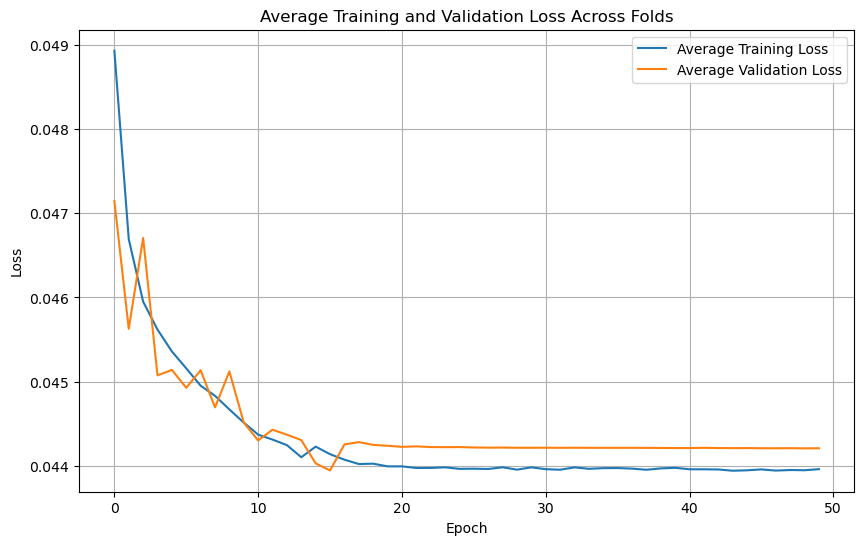

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Determine the maximum number of epochs across all folds
max_epochs = max(len(loss) for loss in train_loss_per_epoch)

# Function to pad each fold's loss history to the maximum length
def pad_loss(loss, max_len):
    return np.pad(loss, (0, max_len - len(loss)), mode='constant', constant_values=np.nan)

# Pad training and validation losses to have the same length across folds
padded_train_loss = np.array([pad_loss(loss, max_epochs) for loss in train_loss_per_epoch])
padded_val_loss = np.array([pad_loss(loss, max_epochs) for loss in val_loss_per_epoch])

# Calculate the average loss across folds, ignoring NaNs
average_train_loss = np.nanmean(padded_train_loss, axis=0)
average_val_loss = np.nanmean(padded_val_loss, axis=0)

# Plot the average training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(average_train_loss, label='Average Training Loss')
plt.plot(average_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss Across Folds')
plt.legend()
plt.grid()
plt.show()


In [3]:
best_hps = tuner.get_best_hyperparameters(num_trials=7)[0]
model = build_cnn_lstm_multihead_attention_model(best_hps)

I0000 00:00:1730065105.033094  213131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730065105.036529  213131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730065105.036609  213131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730065105.039313  213131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730065105.039395  213131 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

2024-10-27 22:38:45.332457: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730065126.268904  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065126.310850  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065126.315313  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065126.338579  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065126.347600  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065126.351008  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065126.360140  246015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065126.363680  246015 gpu_t

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step


W0000 00:00:1730065127.585750  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.588367  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.591881  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.594160  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.597344  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.599689  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.603018  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.605252  246012 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.609938  246012 gp

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


W0000 00:00:1730065127.855512  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.858193  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.860673  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.863759  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.866386  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.869843  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.872313  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.875670  246014 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065127.878065  246014 gp

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 1/44 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

W0000 00:00:1730065128.375126  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.377511  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.380191  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.382071  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.383910  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.386737  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.388602  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.390470  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.393008  246013 gp

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


W0000 00:00:1730065128.769848  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.771813  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.773625  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.776075  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.777790  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.779465  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.781980  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.783717  246013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730065128.785573  246013 gp

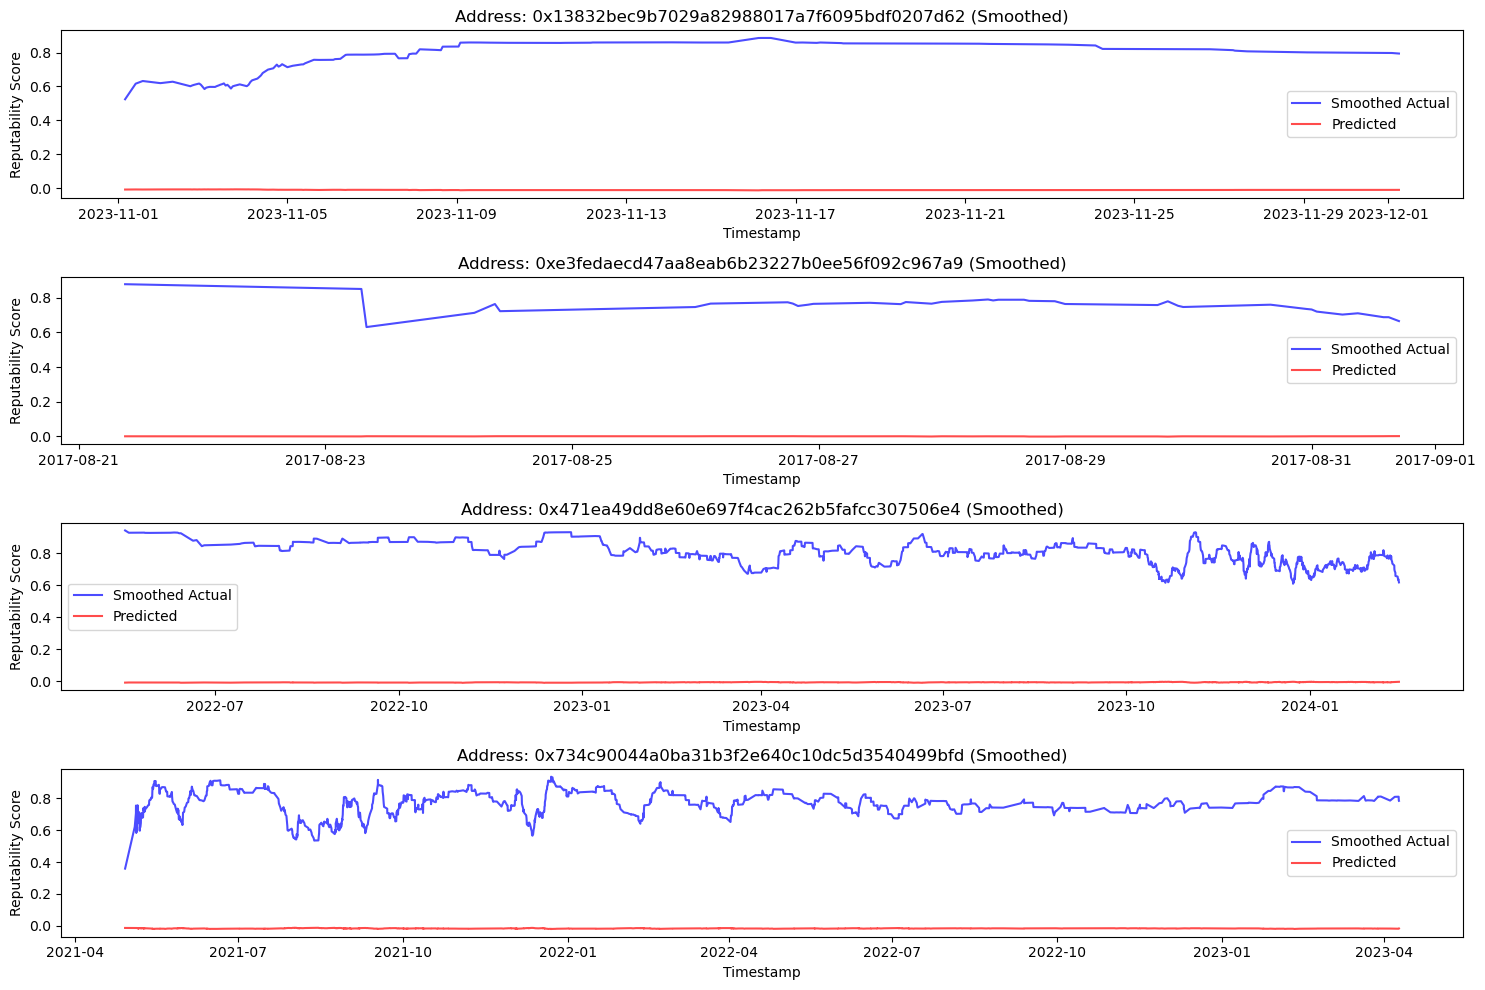

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
window_size = 25
smooth_window_size = 25  # Window size for smoothing
volatility_threshold = 0.05  # Adjust this based on acceptable volatility in reputability scores

# Sample addresses to plot
sample_addresses = [
    '0x13832bec9b7029a82988017a7f6095bdf0207d62',
    '0xe3fedaecd47aa8eab6b23227b0ee56f092c967a9',
    '0x471ea49dd8e60e697f4cac262b5fafcc307506e4',
    '0x734c90044a0ba31b3f2e640c10dc5d3540499bfd',
]

plt.figure(figsize=(15, 10))

# Plot for each address
for i, address in enumerate(sample_addresses):
    plt.subplot(len(sample_addresses), 1, i + 1)
    
    # Filter data for the specific address
    address_data = test_df[test_df['address'] == address]
    
    # Extract timestamps for x-axis
    tmp_addr_data = address_data.to_pandas()
    timestamps = pd.to_datetime(tmp_addr_data['timeStamp'])
    
    # Prepare sequences for the address
    X_address, y_address, _ = prepare_sequences_with_embeddings(address_data, window_size)
    X_address = X_address.reshape((X_address.shape[0], X_address.shape[1], 1))
    
    # Predict reputability scores
    y_pred_address = model.predict([X_address, np.full(X_address.shape[0], address_to_idx[address])])
    
    # Check for volatility in actual scores
    y_std = np.std(y_address)
    
    # Smoothen only if volatility is high
    if y_std > volatility_threshold:
        y_smooth = pd.Series(y_address).rolling(window=smooth_window_size, min_periods=1).mean()
        plt.plot(timestamps[:len(y_smooth)], y_smooth, label='Smoothed Actual', alpha=0.7, color='blue')
        plt.title(f'Address: {address} (Smoothed)')
    else:
        plt.plot(timestamps[:len(y_address)], y_address, label='Actual', alpha=0.7, color='blue')
        plt.title(f'Address: {address}')
    
    # Plot predicted scores
    plt.plot(timestamps[:len(y_pred_address)], y_pred_address, label='Predicted', alpha=0.7, color='red')
    
    # Labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Reputability Score')
    plt.legend()

plt.tight_layout()
plt.show()


In [48]:
test_df_tmp = test_df[test_df['contract_status'] == 0]

In [ ]:
from keras.models import load_model

model = load_model("experiment_")

In [49]:
# Evaluate on the test set
X_test, y_test, contract_ids_test = prepare_sequences_with_embeddings(test_df_tmp, window_size)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
test_loss = model.evaluate([X_test, contract_ids_test], y_test)
print(f'Test Loss: {test_loss}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032
Test Loss: 0.0021757124923169613


W0000 00:00:1729435699.086498  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.088033  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.088882  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.089858  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.090649  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.091430  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.092342  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.094116  513307 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729435699.094892  513307 gp

In [50]:
# Make predictions on the test set
y_pred_test = model.predict([X_test, contract_ids_test])

# Calculate metrics
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f'Test MSE: {mse_test}')
print(f'Test MAE: {mae_test}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test MSE: 0.002055580595370706
Test MAE: 0.0332081869406271


In [51]:
y_test

array([0.07369542, 0.07417768, 0.07900458, 0.08678466, 0.09115225,
       0.09078316, 0.09078316, 0.08999495, 0.08999495, 0.09028054,
       0.09025583, 0.09016482, 0.09043464, 0.09090069, 0.09094527,
       0.09055452, 0.0907366 , 0.09072539, 0.09114497, 0.09232034,
       0.09302365, 0.09306499, 0.07306338, 0.06676105, 0.07548368,
       0.07360462, 0.0783598 , 0.08572343, 0.089984  , 0.08995833,
       0.08995833, 0.09015278, 0.09015278, 0.09005273, 0.09005394,
       0.09020717, 0.09049282, 0.09070776, 0.09074501, 0.02373729,
       0.09505501, 0.02559818, 0.08783706, 0.08055728, 0.03567947,
       0.03664729, 0.08067403, 0.08067429, 0.07975671, 0.03339918,
       0.08659009, 0.08737755, 0.08737775, 0.08646102, 0.08647315,
       0.08651552, 0.08651561, 0.08669396, 0.0868596 , 0.0315737 ,
       0.08784487, 0.08204093, 0.09386484, 0.10166713, 0.10258879,
       0.01790526, 0.10174296, 0.10040035, 0.09869271, 0.09755744,
       0.09955987, 0.09869254, 0.0216852 , 0.09590186, 0.09574

In [52]:
y_pred_test = y_pred_test.ravel()

Statistical Analysis Summary:
Mean Actual: 0.07631705658992807
Mean Predicted: 0.07936787605285645
Standard Deviation Actual: 0.02474497384961143
Standard Deviation Predicted: 0.038657061755657196
Correlation between Actual and Predicted: 0.0316
Mean Squared Error (MSE): 0.0021
Mean Absolute Error (MAE): 0.0332
R-squared (R2): -2.3571


/tmp/ipykernel_509832/584502779.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='orange')


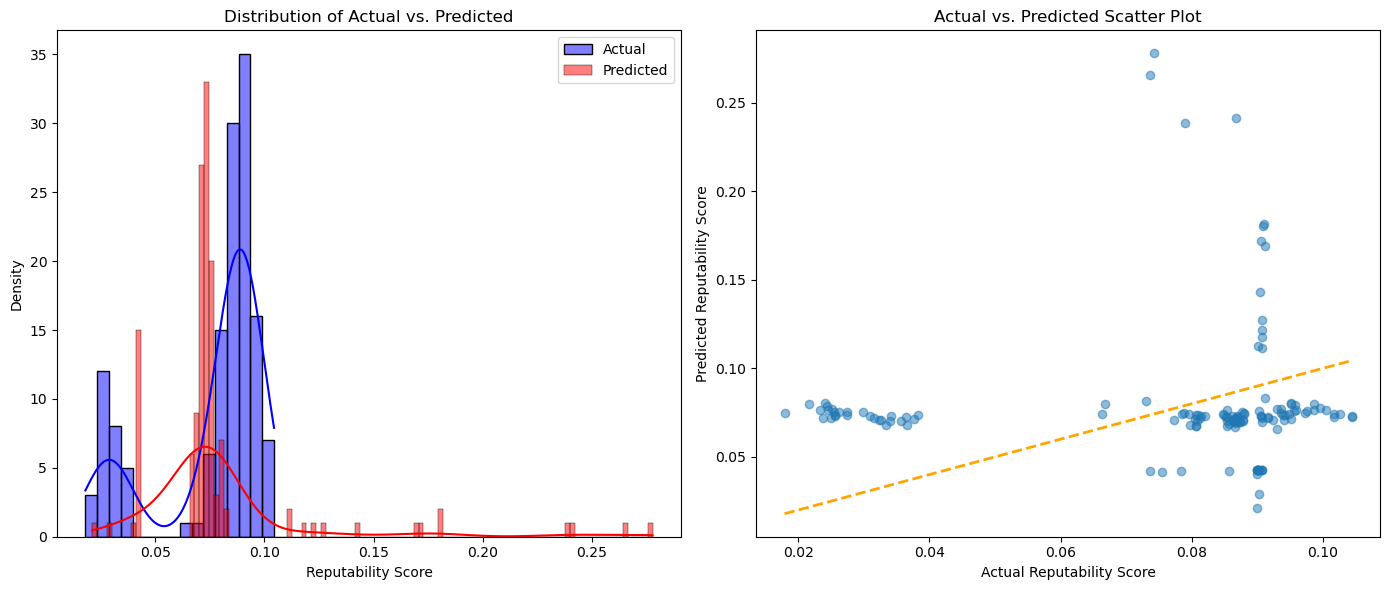

In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create DataFrame for analysis
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

# Calculate statistics
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
corr = np.corrcoef(y_test, y_pred_test)[0, 1]

# Summary statistics
mean_actual = np.mean(y_test)
mean_pred = np.mean(y_pred_test)
std_actual = np.std(y_test)
std_pred = np.std(y_pred_test)

print("Statistical Analysis Summary:")
print(f"Mean Actual: {mean_actual}")
print(f"Mean Predicted: {mean_pred}")
print(f"Standard Deviation Actual: {std_actual}")
print(f"Standard Deviation Predicted: {std_pred}")
print(f"Correlation between Actual and Predicted: {corr:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Additional statistical visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_test, label='Actual', color='blue', kde=True)
sns.histplot(y_pred_test, label='Predicted', color='red', kde=True)
plt.title('Distribution of Actual vs. Predicted')
plt.xlabel('Reputability Score')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='orange')
plt.title('Actual vs. Predicted Scatter Plot')
plt.xlabel('Actual Reputability Score')
plt.ylabel('Predicted Reputability Score')

plt.tight_layout()
plt.show()

In [18]:
test_df_pandas = test_df.to_pandas()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


W0000 00:00:1729434771.077759  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.082081  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.085030  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.089695  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.093650  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.096494  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.102308  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.107075  513310 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729434771.110834  513310 gp

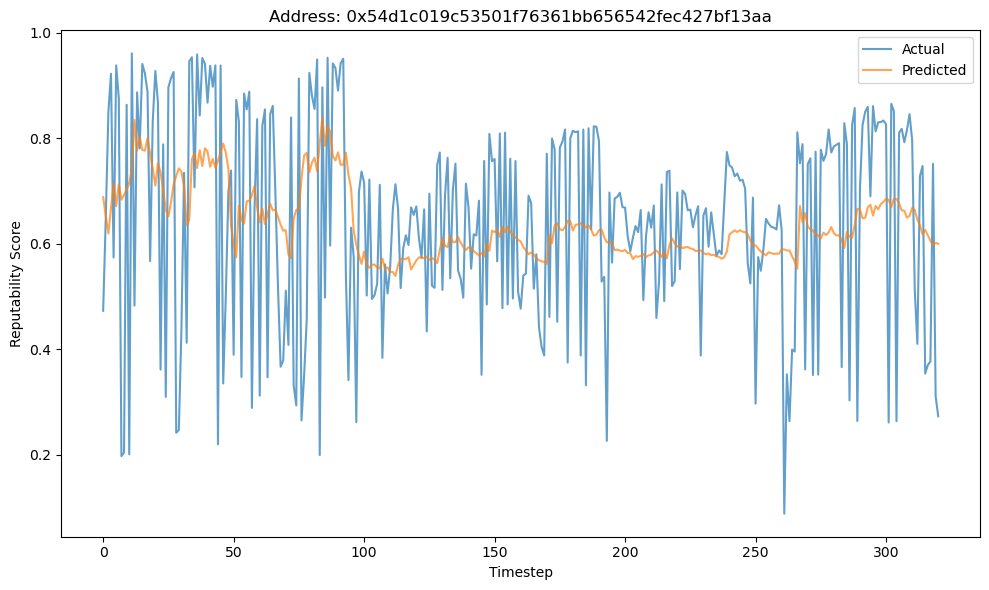

In [23]:
import matplotlib.pyplot as plt

# Plot predictions vs actual for a random contract
random_address = np.random.choice(test_df_pandas['address'].unique())
address_data = test_df[test_df['address'] == random_address]
X_address, y_address, _ = prepare_sequences_with_embeddings(address_data, window_size)
X_address = X_address.reshape((X_address.shape[0], X_address.shape[1], 1))

# Predict for a specific contract address
y_pred_address = model.predict([X_address, np.full(X_address.shape[0], address_to_idx[random_address])])

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_address, label='Actual', alpha=0.7)
plt.plot(y_pred_address, label='Predicted', alpha=0.7)
plt.title(f'Address: {random_address}')
plt.xlabel('Timestep')
plt.ylabel('Reputability Score')
plt.legend()
plt.tight_layout()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

W0000 00:00:1729433922.122932  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.125444  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.127607  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.130878  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.133073  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.136850  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.139041  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.141186  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.143344  513312 gp

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


W0000 00:00:1729433922.349516  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.350519  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.351566  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.352517  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.353547  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.354828  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.355839  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.356658  513312 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729433922.357539  513312 gp

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


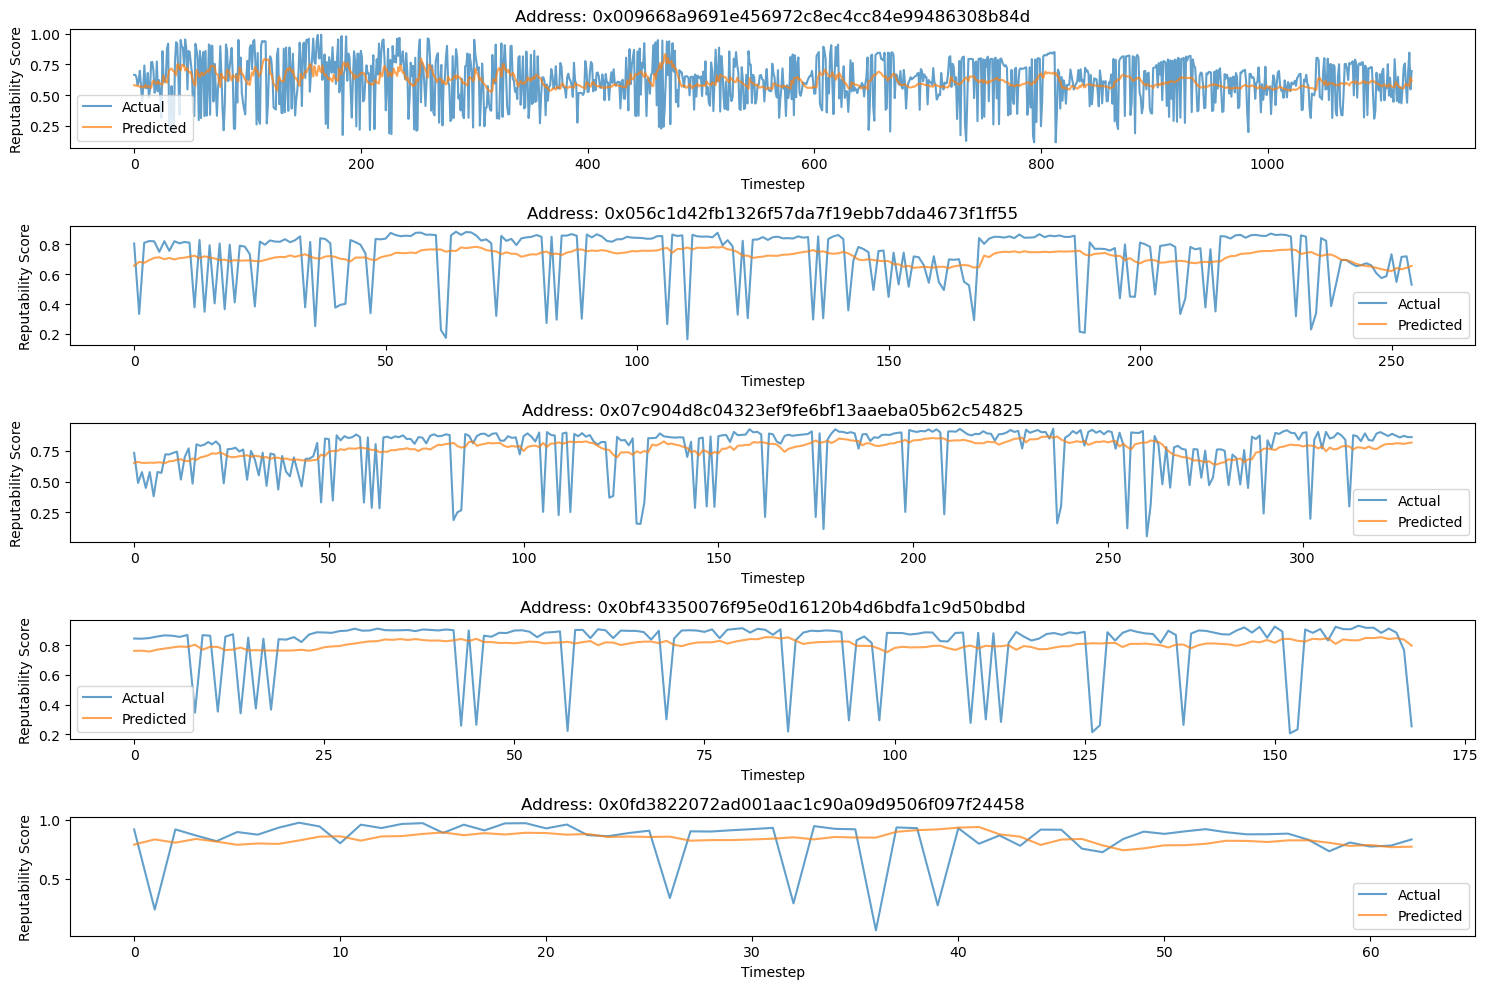

In [6]:
import matplotlib.pyplot as plt

addresses = test_df['address'].unique().to_pandas()
num_addresses_to_plot = 5  # You can adjust this to see more or fewer addresses
sample_addresses = addresses[:num_addresses_to_plot]

plt.figure(figsize=(15, 10))
for i, address in enumerate(sample_addresses):
    plt.subplot(num_addresses_to_plot, 1, i + 1)
    address_data = test_df[test_df['address'] == address]
    X_address, y_address, _ = prepare_sequences_with_embeddings(address_data, window_size)
    X_address = X_address.reshape((X_address.shape[0], X_address.shape[1], 1))
    y_pred_address = model.predict([X_address, np.full(X_address.shape[0], address_to_idx[address])])
    plt.plot(y_address, label='Actual', alpha=0.7)
    plt.plot(y_pred_address, label='Predicted', alpha=0.7)
    plt.title(f'Address: {address}')
    plt.xlabel('Timestep')
    plt.ylabel('Reputability Score')
    plt.legend()

plt.tight_layout()
plt.show()


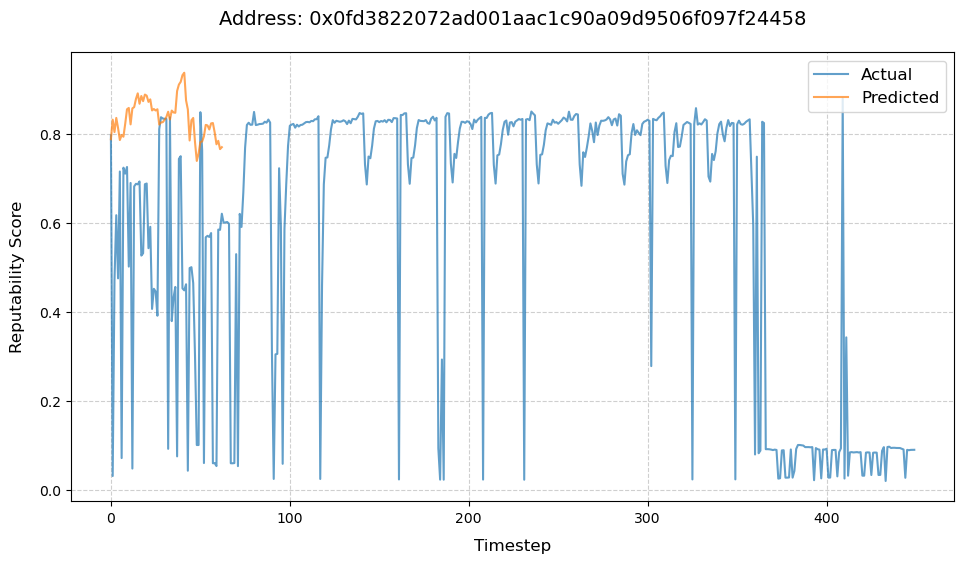

In [7]:
# 0x536a6ba0d913d5d6a4ce2c6eb7ed0de3c0f0b89e     #

address_data = df[df['address'] == '0x536a6ba0d913d5d6a4ce2c6eb7ed0de3c0f0b89e']
X_address, y_address, _ = prepare_sequences_with_embeddings(address_data, window_size)
X_address = X_address.reshape((X_address.shape[0], X_address.shape[1], 1))

# Adjust figure size and padding
plt.figure(figsize=(10, 6))  # Increase figure size

# Plot the actual and predicted values
plt.plot(y_address, label='Actual', alpha=0.7,)
plt.plot(y_pred_address, label='Predicted', alpha=0.7)

# Add title and labels with proper spacing
plt.title(f'Address: {address}', fontsize=14, pad=20)  # Increase padding for the title
plt.xlabel('Timestep', fontsize=12, labelpad=10)  # Increase label padding
plt.ylabel('Reputability Score', fontsize=12, labelpad=10)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Display the legend with better positioning
plt.legend(loc='upper right', fontsize=12)

# Increase space around the plot
plt.tight_layout(pad=2.0)

# Show the plot
plt.show()



In [13]:
y_address

array([0.79764002, 0.03089077, 0.47107257, 0.61792504, 0.47576294,
       0.71626815, 0.07128683, 0.72489018, 0.71150254, 0.72643912,
       0.50228729, 0.69047352, 0.04769877, 0.6827245 , 0.68855877,
       0.68741565, 0.69389977, 0.52700595, 0.53221922, 0.68764816,
       0.68924794, 0.54369187, 0.5917807 , 0.40700423, 0.45224762,
       0.44629108, 0.39167348, 0.81170876, 0.83848352, 0.83561402,
       0.83481054, 0.8348197 , 0.09210066, 0.83847167, 0.37957005,
       0.43219206, 0.45646992, 0.07507902, 0.74469624, 0.75076681,
       0.45322253, 0.44877507, 0.46243128, 0.04282368, 0.49897588,
       0.50092133, 0.46522951, 0.3023753 , 0.10064368, 0.10064377,
       0.84980189, 0.76380417, 0.0600664 , 0.5682393 , 0.57151814,
       0.56897377, 0.57777583, 0.05958835, 0.05998285, 0.05329877,
       0.58560859, 0.58495744, 0.62124171, 0.60076614, 0.6016961 ,
       0.60263113, 0.59873735, 0.05957249, 0.05955581, 0.0599916 ,
       0.53025134, 0.05313446, 0.62087687, 0.59153423, 0.66894

In [14]:
y_pred_address

array([[0.78893656],
       [0.8329525 ],
       [0.8050777 ],
       [0.836873  ],
       [0.8141912 ],
       [0.78710324],
       [0.7984643 ],
       [0.7945804 ],
       [0.82382816],
       [0.8564223 ],
       [0.8593567 ],
       [0.82237697],
       [0.8584126 ],
       [0.8612069 ],
       [0.87958527],
       [0.8922131 ],
       [0.86879313],
       [0.8862133 ],
       [0.87468696],
       [0.8895053 ],
       [0.8870225 ],
       [0.87300205],
       [0.87865967],
       [0.8537831 ],
       [0.85696864],
       [0.8536104 ],
       [0.8564322 ],
       [0.82194185],
       [0.8267916 ],
       [0.827305  ],
       [0.83258194],
       [0.8389669 ],
       [0.85080516],
       [0.83326375],
       [0.85342795],
       [0.84922904],
       [0.8484464 ],
       [0.8975889 ],
       [0.9119826 ],
       [0.91810966],
       [0.9331817 ],
       [0.9385948 ],
       [0.876485  ],
       [0.85600334],
       [0.78611946],
       [0.8315428 ],
       [0.83681965],
       [0.782

# Multi-Task CNN-LSTM Model

## Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Activation, Dropout, Flatten, Embedding, Concatenate, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
from sklearn.model_selection import KFold
import numpy as np
import csv
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Multi-task Learning Model Builder for Keras Tuner
def build_multitask_model(hp):
    # Hyperparameter tuning
    num_filters = hp.Choice('num_filters', values=[32, 64, 128])
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128])
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3])
    l2_reg = hp.Choice('l2_reg', values=[1e-4, 1e-3, 1e-2])

    # Input Layer for Reputability Score Time Series
    input_rep_scores = Input(shape=(window_size, 1), name='rep_score_input')

    # CNN Layer for extracting short-term features
    x = Conv1D(filters=num_filters, kernel_size=3, padding='same', kernel_regularizer=l2(l2_reg))(input_rep_scores)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    # LSTM Layer for long-term dependencies
    lstm_output = LSTM(lstm_units, return_sequences=True, activation=activation)(x)
    lstm_output = Dropout(dropout_rate)(lstm_output)

    # Multi-Head Attention Layer for improved feature learning
    attention_output = MultiHeadAttention(num_heads=4, key_dim=lstm_units)(lstm_output, lstm_output)

    # Flatten attention output before combining with other inputs
    attention_output = Flatten()(attention_output)

    # Input for Contract Embedding
    input_contracts = Input(shape=(1,), name='contract_input')
    contract_embedding = Embedding(input_dim=len(unique_addresses), output_dim=10)(input_contracts)
    contract_embedding = Flatten()(contract_embedding)

    # Concatenate Attention-LSTM output with Contract Embedding
    combined = Concatenate()([attention_output, contract_embedding])

    # Task-specific output for Reputable contracts
    reputable_output = Dense(1, activation='linear', name='reputable_output')(combined)

    # Task-specific output for Illicit contracts
    illicit_output = Dense(1, activation='linear', name='illicit_output')(combined)

    # Compile the Model with multi-task losses
    model = Model(inputs=[input_rep_scores, input_contracts], outputs=[reputable_output, illicit_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model

# Keras Tuner for Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_multitask_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='multitask_hyperparam_tuning',
    project_name='experiment_3_multitask'
)

# Prepare the data for training
X, y, contract_ids = prepare_sequences_with_embeddings(df, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Splitting the targets into two separate labels for reputable and illicit
y_reputable = y[df['contract_status'] == 1]  # Assuming contract_status is 1 for reputable
y_illicit = y[df['contract_status'] == 0]  # Assuming contract_status is 0 for illicit

# K-Fold Cross Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_num = 1
all_fold_results = []
fold_results = []
hyperparameter_results = []

for train_index, val_index in kf.split(X):
    print(f'Fold {fold_num} of K-Fold Cross Validation')
    X_train, X_val = X[train_index], X[val_index]
    y_train_rep, y_val_rep = y_reputable[train_index], y_reputable[val_index]
    y_train_ill, y_val_ill = y_illicit[train_index], y_illicit[val_index]
    contract_ids_train, contract_ids_val = contract_ids[train_index], contract_ids[val_index]

    # Search for the best hyperparameters for this fold
    tuner.search([X_train, contract_ids_train], [y_train_rep, y_train_ill],
                 validation_data=([X_val, contract_ids_val], [y_val_rep, y_val_ill]),
                 epochs=50,
                 batch_size=32,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    # Iterate through all trials and record their losses
    for trial in tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)):
        trial_hps = trial.hyperparameters.values
        trial_val_loss = trial.score

        hyperparameter_results.append({
            'Fold': fold_num,
            'Trial': trial.trial_id,
            'Validation Loss': trial_val_loss,
            'Num Filters': trial_hps.get('num_filters'),
            'LSTM Units': trial_hps.get('lstm_units'),
            'Learning Rate': trial_hps.get('learning_rate'),
            'Activation': trial_hps.get('activation'),
            'Dropout Rate': trial_hps.get('dropout_rate'),
            'L2 Regularization': trial_hps.get('l2_reg'),
        })

    # Get the optimal hyperparameters for this fold
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build the model with the best hyperparameters
    model = build_multitask_model(best_hps)

    # Train the model for this fold
    history = model.fit([X_train, contract_ids_train], [y_train_rep, y_train_ill],
                        validation_data=([X_val, contract_ids_val], [y_val_rep, y_val_ill]),
                        epochs=50,
                        batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3),
                                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)])

    # Evaluate on validation set
    val_loss_rep = model.evaluate([X_val, contract_ids_val], y_val_rep)
    val_loss_ill = model.evaluate([X_val, contract_ids_val], y_val_ill)

    # Save per-fold results, including hyperparameters
    fold_results.append({
        'Fold': fold_num,
        'Validation Loss (Reputable)': val_loss_rep,
        'Validation Loss (Illicit)': val_loss_ill,
        'Num Filters': best_hps.get('num_filters'),
        'LSTM Units': best_hps.get('lstm_units'),
        'Learning Rate': best_hps.get('learning_rate'),
        'Activation': best_hps.get('activation'),
        'Dropout Rate': best_hps.get('dropout_rate'),
        'L2 Regularization': best_hps.get('l2_reg'),
    })

    fold_num += 1

# Save per-fold results to CSV
fold_results_file = 'experiment_3_fold_results_multitask.csv'
with open(fold_results_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['Fold', 'Validation Loss (Reputable)', 'Validation Loss (Illicit)', 'Num Filters', 'LSTM Units', 'Learning Rate', 'Activation', 'Dropout Rate', 'L2 Regularization'])
    writer.writeheader()
    writer.writerows(fold_results)

# Save hyperparameter tuning results to CSV
hyperparameter_results_file = 'experiment_3_hyperparameter_results_multitask.csv'
with open(hyperparameter_results_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['Fold', 'Trial', 'Validation Loss', 'Num Filters', 'LSTM Units', 'Learning Rate', 'Activation', 'Dropout Rate', 'L2 Regularization'])
    writer.writeheader()
    writer.writerows(hyperparameter_results)

# Average validation loss across all folds
avg_val_loss = np.mean([result['Validation Loss (Reputable)'] for result in fold_results] +
                       [result['Validation Loss (Illicit)'] for result in fold_results])
print(f'Average Validation Loss across all folds: {avg_val_loss}')

# Save average results to CSV
avg_results_file = 'experiment_3_avg_results_multitask.csv'
with open(avg_results_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['Average Validation Loss'])
    writer.writeheader()
    writer.writerow({'Average Validation Loss': avg_val_loss})


# Sample Model

In [32]:
# Hyperparameters for this specific training
window_size = 25
lstm_units = 32
num_filters = 64
learning_rate = 0.0005
activation = 'tanh'
dropout_rate = 0.1
l2_reg = 0.0001

# Function to build the model with the given hyperparameters
def build_sample_model():
    # Input Layer for Reputability Score Time Series
    input_rep_scores = Input(shape=(window_size, 1), name='rep_score_input')
    
    # CNN Layer for extracting short-term features
    x = Conv1D(filters=num_filters, kernel_size=3, padding='same', kernel_regularizer=l2(l2_reg))(input_rep_scores)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)
    
    # LSTM Layer for long-term dependencies
    lstm_output = LSTM(lstm_units, return_sequences=True, activation=activation)(x)
    lstm_output = Dropout(dropout_rate)(lstm_output)
    
    # Flatten before combining with other inputs
    lstm_output = Flatten()(lstm_output)
    
    # Input for Contract Embedding
    input_contracts = Input(shape=(1,), name='contract_input')
    contract_embedding = Embedding(input_dim=len(unique_addresses), output_dim=10)(input_contracts)
    contract_embedding = Flatten()(contract_embedding)
    
    # Concatenate the LSTM output with Contract Embedding
    combined = Concatenate()([lstm_output, contract_embedding])
    
    # Output Layer for Reputability Score Prediction
    reputable_output = Dense(1, activation='linear', name='reputable_output')(combined)
    illicit_output = Dense(1, activation='linear', name='illicit_output')(combined)
    
    # Compile the Model
    model = Model(inputs=[input_rep_scores, input_contracts], outputs=[reputable_output, illicit_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model

# Prepare the data for training
# df = df.to_pandas()  # Convert to pandas for compatibility with Keras
# Splitting the DataFrame based on contract_status
reputable_df = df[df['contract_status'] == 1]
illicit_df = df[df['contract_status'] == 0]

# Prepare the data for reputable contracts
X_reputable, y_reputable, contract_ids_reputable = prepare_sequences_with_embeddings(reputable_df, window_size)
X_reputable = X_reputable.reshape((X_reputable.shape[0], X_reputable.shape[1], 1))

# Prepare the data for illicit contracts
X_illicit, y_illicit, contract_ids_illicit = prepare_sequences_with_embeddings(illicit_df, window_size)
X_illicit = X_illicit.reshape((X_illicit.shape[0], X_illicit.shape[1], 1))

# Build the model
model = build_sample_model()

# Train the model on reputable and illicit data separately
history = model.fit([X_reputable, contract_ids_reputable], [y_reputable, y_reputable],
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)])

# Evaluate on illicit dataset separately
val_loss_illicit = model.evaluate([X_illicit, contract_ids_illicit], y_illicit)
print(f'Validation Loss for Illicit Data: {val_loss_illicit}')

# Save the model
model.save('experiment_3_sample_model.h5')

# Save results to CSV
fold_results = [{
    'Validation Loss (Illicit)': val_loss_illicit,
    'LSTM Units': lstm_units,
    'Num Filters': num_filters,
    'Learning Rate': learning_rate,
    'Activation': activation,
    'Dropout Rate': dropout_rate,
    'L2 Regularization': l2_reg
}]

fold_results_file = 'experiment_3_sample_results.csv'
with open(fold_results_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['Validation Loss (Illicit)', 'LSTM Units', 'Num Filters', 'Learning Rate', 'Activation', 'Dropout Rate', 'L2 Regularization'])
    writer.writeheader()
    writer.writerows(fold_results)

I0000 00:00:1729438450.352663  573724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729438450.355543  573724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729438450.355605  573724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729438450.357305  573724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729438450.357370  573724 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


2024-10-20 17:34:13.242932: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729438453.454264  577156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438453.488992  577156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438453.492151  577156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438453.493883  577156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438453.505690  577156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438453.512115  577156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438453.527012  577156 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438453.528843  577156 gpu_t

   4/5760 ━━━━━━━━━━━━━━━━━━━━ 1:48 19ms/step - illicit_output_loss: 0.8859 - loss: 1.5727 - reputable_output_loss: 0.6866 

W0000 00:00:1729438454.781008  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.786123  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.792038  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.794348  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.798434  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.800693  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.803948  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.807044  577153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438454.810280  577153 gp

5760/5760 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - illicit_output_loss: 0.0568 - loss: 0.1127 - reputable_output_loss: 0.0557

W0000 00:00:1729438530.655652  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.657447  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.658982  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.660468  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.662099  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.663564  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.665035  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.666562  577157 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438530.668051  577157 gp

5760/5760 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - illicit_output_loss: 0.0568 - loss: 0.1127 - reputable_output_loss: 0.0557 - val_illicit_output_loss: 0.0460 - val_loss: 0.0921 - val_reputable_output_loss: 0.0459 - learning_rate: 5.0000e-04
Epoch 2/50
   5/5760 ━━━━━━━━━━━━━━━━━━━━ 1:29 16ms/step - illicit_output_loss: 0.0344 - loss: 0.0680 - reputable_output_loss: 0.0335

W0000 00:00:1729438538.428019  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.430109  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.432090  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.435904  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.437893  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.440548  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.442556  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.444543  577154 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729438538.446543  577154 gp

5760/5760 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - illicit_output_loss: 0.0479 - loss: 0.0959 - reputable_output_loss: 0.0479 - val_illicit_output_loss: 0.0462 - val_loss: 0.0926 - val_reputable_output_loss: 0.0462 - learning_rate: 5.0000e-04
Epoch 3/50
5760/5760 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - illicit_output_loss: 0.0474 - loss: 0.0949 - reputable_output_loss: 0.0474 - val_illicit_output_loss: 0.0452 - val_loss: 0.0907 - val_reputable_output_loss: 0.0453 - learning_rate: 5.0000e-04
Epoch 4/50
5760/5760 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - illicit_output_loss: 0.0469 - loss: 0.0940 - reputable_output_loss: 0.0469 - val_illicit_output_loss: 0.0450 - val_loss: 0.0903 - val_reputable_output_loss: 0.0451 - learning_rate: 5.0000e-04
Epoch 5/50
5760/5760 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - illicit_output_loss: 0.0468 - loss: 0.0939 - reputable_output_loss: 0.0468 - val_illicit_output_loss: 0.0452 - val_loss: 0.0905 - val_reputable_output_loss: 0.0451 - learning_rate: 5.0000e-04
Epoch 6/50


W0000 00:00:1729439528.519106  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.521407  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.523454  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.525906  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.527715  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.529537  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.531331  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.534176  577150 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729439528.536870  577150 gp

Validation Loss for Illicit Data: [0.1132717877626419, 0.1128418818116188, 0.0]


In [53]:
# Filter the test dataset for illicit contracts (contract_status == 0)
test_illicit_df = test_df[test_df['contract_status'] == 0]

# Prepare the test data for illicit contracts
X_illicit_test, y_illicit_test, contract_ids_illicit_test = prepare_sequences_with_embeddings(test_illicit_df, window_size)
X_illicit_test = X_illicit_test.reshape((X_illicit_test.shape[0], X_illicit_test.shape[1], 1))

# Predict for illicit contracts
predictions = model.predict([X_illicit_test, contract_ids_illicit_test])

# Extract reputable and illicit predictions separately
y_pred_reputable_illicit_test = predictions[0].flatten()  # Predictions for reputable output
y_pred_illicit_test = predictions[1].flatten()  # Predictions for illicit output

# Filter the test dataset for reputable contracts (contract_status == 1)
test_reputable_df = test_df[test_df['contract_status'] == 1]

# Prepare the test data for reputable contracts
X_reputable_test, y_reputable_test, contract_ids_reputable_test = prepare_sequences_with_embeddings(test_reputable_df, window_size)
X_reputable_test = X_reputable_test.reshape((X_reputable_test.shape[0], X_reputable_test.shape[1], 1))
# Predict for reputable contracts
predictions_reputable = model.predict([X_reputable_test, contract_ids_reputable_test])

# Extract reputable and illicit predictions separately
y_pred_reputable_reputable_test = predictions_reputable[0].flatten()  # Predictions for reputable output
y_pred_illicit_reputable_test = predictions_reputable[1].flatten()  # Predictions for illicit output


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [38]:
y_pred_test = model.predict([X_test, contract_ids_test])

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


Statistical Analysis Summary for Reputable Contracts:
Mean Actual: 0.6956835680250828
Mean Predicted: 0.6908084750175476
Standard Deviation Actual: 0.2350794299695634
Standard Deviation Predicted: 0.09171466529369354
Correlation between Actual and Predicted: 0.4035
Mean Squared Error (MSE): 0.0463
Mean Absolute Error (MAE): 0.1695
R-squared (R2): 0.1622

Statistical Analysis Summary for Illicit Contracts:
Mean Actual: 0.07631705658992807
Mean Predicted: 0.2983798384666443
Standard Deviation Actual: 0.02474497384961143
Standard Deviation Predicted: 0.34222471714019775
Correlation between Actual and Predicted: 0.1206
Mean Squared Error (MSE): 0.1650
Mean Absolute Error (MAE): 0.2221
R-squared (R2): -268.4695



/tmp/ipykernel_573724/731972839.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([results_reputable_df['Actual'].min(), results_reputable_df['Actual'].max()],
/tmp/ipykernel_573724/731972839.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([results_illicit_df['Actual'].min(), results_illicit_df['Actual'].max()],


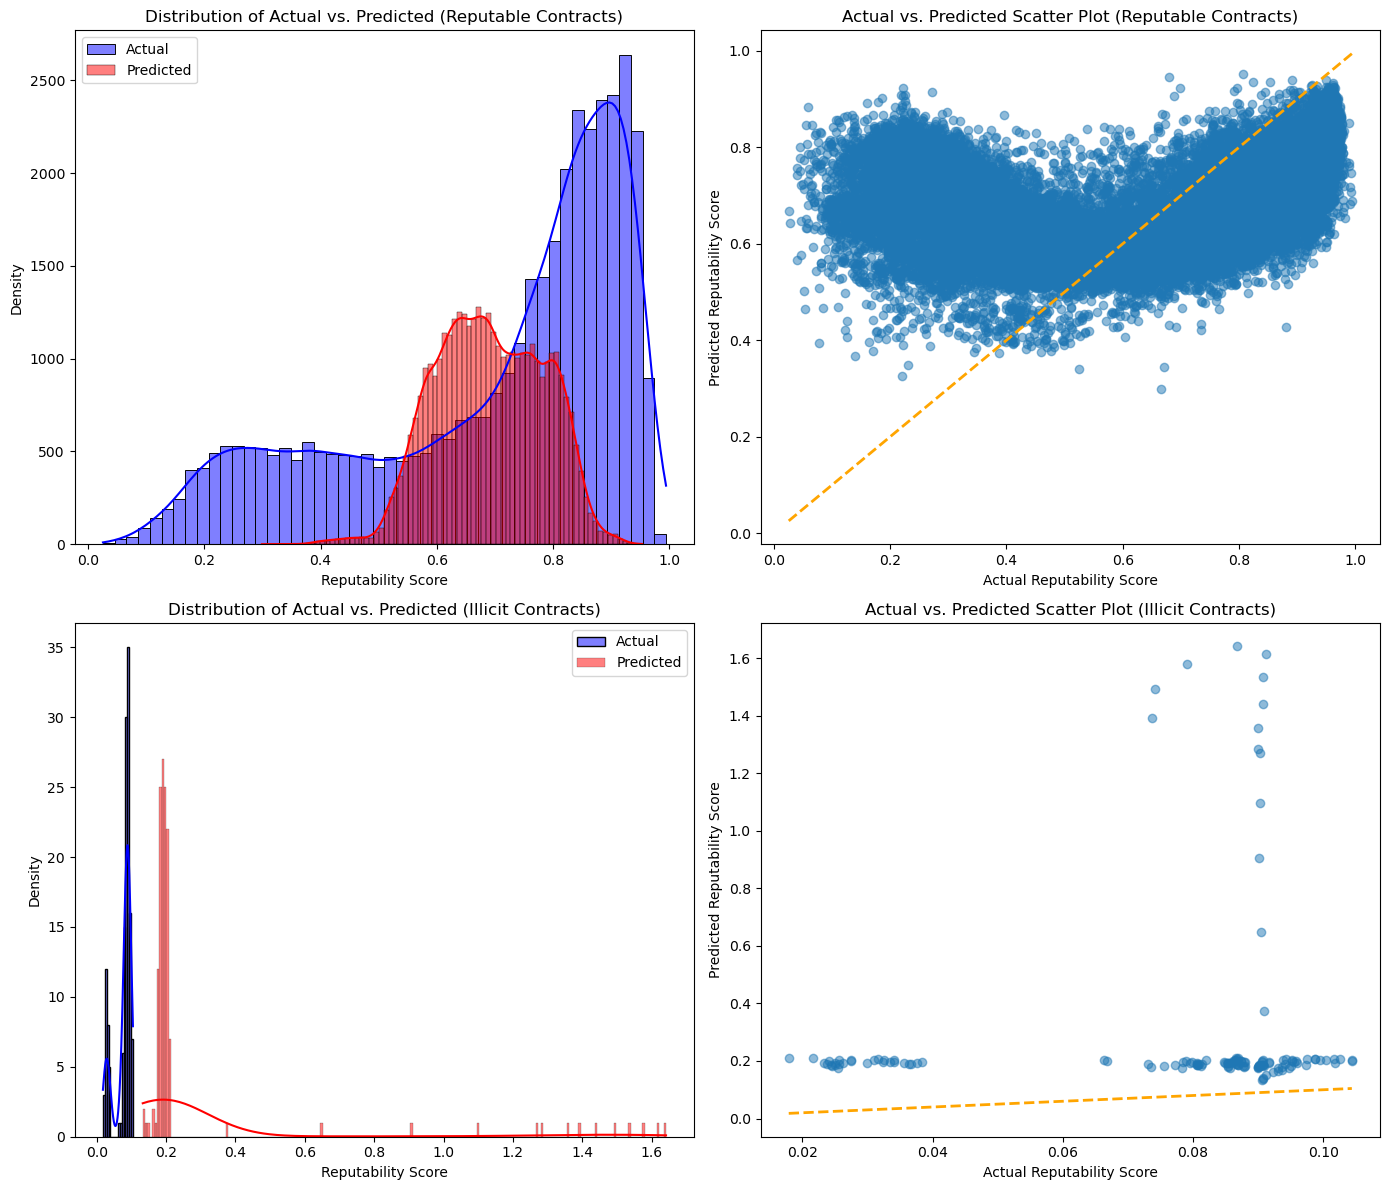

In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create DataFrames for analysis
results_reputable_df = pd.DataFrame({'Actual': y_reputable_test, 'Predicted': y_pred_reputable_reputable_test})
results_illicit_df = pd.DataFrame({'Actual': y_illicit_test, 'Predicted': y_pred_illicit_test})

# Function to calculate and display metrics
def analyze_results(y_actual, y_pred, label):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    corr = np.corrcoef(y_actual, y_pred)[0, 1]

    mean_actual = np.mean(y_actual)
    mean_pred = np.mean(y_pred)
    std_actual = np.std(y_actual)
    std_pred = np.std(y_pred)

    print(f"Statistical Analysis Summary for {label}:")
    print(f"Mean Actual: {mean_actual}")
    print(f"Mean Predicted: {mean_pred}")
    print(f"Standard Deviation Actual: {std_actual}")
    print(f"Standard Deviation Predicted: {std_pred}")
    print(f"Correlation between Actual and Predicted: {corr:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}\n")

# Analyze reputable contracts
analyze_results(results_reputable_df['Actual'], results_reputable_df['Predicted'], "Reputable Contracts")

# Analyze illicit contracts
analyze_results(results_illicit_df['Actual'], results_illicit_df['Predicted'], "Illicit Contracts")

# Additional statistical visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution plots for reputable contracts
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
sns.histplot(results_reputable_df['Actual'], label='Actual', color='blue', kde=True)
sns.histplot(results_reputable_df['Predicted'], label='Predicted', color='red', kde=True)
plt.title('Distribution of Actual vs. Predicted (Reputable Contracts)')
plt.xlabel('Reputability Score')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(results_reputable_df['Actual'], results_reputable_df['Predicted'], alpha=0.5)
plt.plot([results_reputable_df['Actual'].min(), results_reputable_df['Actual'].max()],
         [results_reputable_df['Actual'].min(), results_reputable_df['Actual'].max()],
         'k--', lw=2, color='orange')
plt.title('Actual vs. Predicted Scatter Plot (Reputable Contracts)')
plt.xlabel('Actual Reputability Score')
plt.ylabel('Predicted Reputability Score')

# Distribution plots for illicit contracts
plt.subplot(2, 2, 3)
sns.histplot(results_illicit_df['Actual'], label='Actual', color='blue', kde=True)
sns.histplot(results_illicit_df['Predicted'], label='Predicted', color='red', kde=True)
plt.title('Distribution of Actual vs. Predicted (Illicit Contracts)')
plt.xlabel('Reputability Score')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(results_illicit_df['Actual'], results_illicit_df['Predicted'], alpha=0.5)
plt.plot([results_illicit_df['Actual'].min(), results_illicit_df['Actual'].max()],
         [results_illicit_df['Actual'].min(), results_illicit_df['Actual'].max()],
         'k--', lw=2, color='orange')
plt.title('Actual vs. Predicted Scatter Plot (Illicit Contracts)')
plt.xlabel('Actual Reputability Score')
plt.ylabel('Predicted Reputability Score')

plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create DataFrame for analysis
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

# Calculate statistics
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
corr = np.corrcoef(y_test, y_pred_test)[0, 1]

# Summary statistics
mean_actual = np.mean(y_test)
mean_pred = np.mean(y_pred_test)
std_actual = np.std(y_test)
std_pred = np.std(y_pred_test)

print("Statistical Analysis Summary:")
print(f"Mean Actual: {mean_actual}")
print(f"Mean Predicted: {mean_pred}")
print(f"Standard Deviation Actual: {std_actual}")
print(f"Standard Deviation Predicted: {std_pred}")
print(f"Correlation between Actual and Predicted: {corr:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Additional statistical visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_test, label='Actual', color='blue', kde=True)
sns.histplot(y_pred_test, label='Predicted', color='red', kde=True)
plt.title('Distribution of Actual vs. Predicted')
plt.xlabel('Reputability Score')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='orange')
plt.title('Actual vs. Predicted Scatter Plot')
plt.xlabel('Actual Reputability Score')
plt.ylabel('Predicted Reputability Score')

plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length